# Glitch rises as a test for rapid superfluid coupling in neutron stars -- theoretical model
---

In [1]:
#!/usr/bin/env python
"""rapid_crust_coupling.ipynb: a notebook to recreate results of Graber et al. (2018)"""

__author__ = "Vanessa Graber"
__copyright__ = "Copyright 2018"
__credits__ = ["Vanessa Graber"]
__license__ = "MIT"
__maintainer__ = "Vanessa Graber"
__email__ = "vanessa.graber@mcgill.ca"

This notebook contains code to reproduce part of the results of [Graber et al. (2018)](http://arxiv.org/abs/1804.02706). Focusing on the theoretical predictions, this notebook includes the integration of the TOV equations for a specific crust model to obtain the mutual friction coefficients $\mathcal{B}$ as a function of radius $\tilde{r}$ and relative mass fraction $\Delta M /M$, and the numerical integration of a simple three-component neutron star toy model, providing the time evolution of the angular velocities $\Omega_{\rm sf}, \Omega_{\rm core}$ and $\Omega_{\rm crust}$.

Comparison to the first pulse-to-pulse observation of a glitch in the Vela pulsar ([Palfreyman et al. (2018)](https://www.nature.com/articles/s41586-018-0001-x)) can be found in an accompanying [notebook]().

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.animation as animation
from IPython.display import HTML
import sys
import os

In [3]:
%matplotlib inline

# Set `usetex=False' if you do not have LaTeX installed.
rc('text', usetex=True)
rc('font', family='serif')
mpl.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
mpl.rcParams['animation.ffmpeg_path'] = os.path.join(os.path.dirname(sys.executable), 'ffmpeg')

Physical constants in cgs units and conversion factors:

In [4]:
from scipy.constants import pi, c, hbar, u, G, m_e, k, eV
hbar = hbar*1e7
m = u*1e3
m_e = m_e*1e3
q = 4.80320425e-10
c = c * 1e2
k_B = k
kappa = hbar*pi/m
G = G*1e3
Msun = 1.98855e33
mu = 2*m/5
eV = eV*1e7
fm = 1e-13
cm = 1e13

## Microscopic parameters
---

Import the microscopic parameters from Negele and Vautherin (1973), Donati and Pizzochero (2006) and Epstein and Baym (1992). 

In [5]:
df_EoS = pd.read_csv("microscopic_parameters.txt", sep="&", skiprows=5)
df_EoS.columns = ['n_b', 'Z', 'N', 'x', 'n_s', r'$\xi$', 'E_p', 'R_N', 'E_l', 'E_s']

In [6]:
df_EoS[r'$\rho$ [$10^{12}$]'] = m*df_EoS['n_b']*fm**(-3)*1e-12
df_EoS['A'] = np.round(df_EoS['Z']*(1 + 1/df_EoS['x']))
df_EoS['R_WS'] = (3*(df_EoS['N'] + df_EoS['Z'])/(4*pi*df_EoS['n_b']))**(1/3)
df_EoS['n_l [$10^{-6}$]'] = 3/(4*pi*df_EoS['R_WS']**3)*1e6
df_EoS['a'] = (2/(df_EoS['n_l [$10^{-6}$]']*1e-6))**(1/3)
df_EoS['$\Delta$'] = hbar**2*(3*pi**2*df_EoS['n_s']*fm**(-3))**(1/3)/(pi*m*df_EoS[r'$\xi$']*fm*eV*1e6)

In [7]:
df_EoS[r'$\rho$ [$10^{12}$]'] = np.round(df_EoS[r'$\rho$ [$10^{12}$]'], 1)
df_EoS['R_WS'] = np.round(df_EoS['R_WS'], 1)
df_EoS['n_l [$10^{-6}$]'] = np.round(df_EoS['n_l [$10^{-6}$]'], 1)
df_EoS['a'] = np.round(df_EoS['a'], 1)
df_EoS['$\Delta$'] = np.round(df_EoS['$\Delta$'], 2)

In [8]:
df_EoS

,n_b,Z,N,x,n_s,$\xi$,E_p,R_N,E_l,E_s,$\rho$ [$10^{12}$],A,R_WS,n_l [$10^{-6}$],a,$\Delta$
0,0.000879,40,280,0.53,0.00048,15.6,0.21,5.9,0.16,0.42,1.5,115.0,44.3,2.7,90.0,0.21
1,0.005770,50,1050,0.45,0.00470,10.1,0.29,6.7,0.94,-0.13,9.6,161.0,35.7,5.2,72.5,0.68
2,0.020400,50,1750,0.35,0.01840,12.0,-2.74,7.2,1.40,-1.64,33.9,193.0,27.6,11.3,56.1,0.91
3,0.047500,40,1460,0.28,0.04360,26.1,-0.72,7.3,1.00,-1.00,78.9,183.0,19.6,31.7,39.8,0.56
4,0.078900,32,950,0.16,0.07370,90.8,-0.02,7.2,0.49,-0.78,131.0,232.0,14.4,80.3,29.2,0.19


## TOV equation
---

### Equation of state

For the inner crust above neutron drip we use the fitted EoS of Negele and Vautherin (1973) (see their equations on page 317). The baryon density has to be given in $\text{cm}^{-3}$ and the pressure is returned in ${\rm dyne}/{\rm cm}^2$.

In [9]:
fit_params_EoS = np.array([-4.0, 2.8822899e-1, 5.9150523e-1, 9.0185940e-2, -1.1025614e-1,
                           2.9377479e-2, -3.2618465e-3, 1.3543555e-4])

In [10]:
def sum_energy(n_b, c_i):
    """sum given by Negele and Vautherin to fit the energy, answer in MeV"""
    return np.sum([c*np.log(n_b*1e-35)**(i-1) for i, c in enumerate(c_i) if i > 0])


def sum_pressure(n_b, c_i):
    """sum given by Negele and Vautherin to fit the pressure"""
    return np.sum([c*(i-1)*np.log(n_b*1e-35)**(i-2) for i, c in enumerate(c_i) if i > 0])


def P_inner_crust(rho, c_i):
    """pressure in the inner crust given in dyne/cm^2"""
    return (rho/m)*sum_pressure(rho/m, c_i)*np.exp(sum_energy(rho/m, c_i))*1e6*eV

Below neutron drip the Negele and Vautherin EoS no longer applies and we take the pressure to be dominated by relativistic electrons with $Y_{\rm e} \approx 0.4$.

In [11]:
rho_drip = 4e11

In [12]:
def P_outer_crust(rho):
    """pressure in the outer crust given in dyne/cm^2"""
    Y_e = 0.4
    P_e = hbar*c*(3*pi**2/m)**(4/3)/(12*pi**2)*(Y_e*rho)**(4/3)
    return P_e

EoS and inverse EoS for the full crust:

In [13]:
def pressure(rho, c_i, rho_drip):
    """pressure calculated as a function of density given in g/cm^3, answer in dyne/cm^2"""
    if rho < 0:
        return 0
    if rho >= rho_drip:
        return P_inner_crust(rho, c_i)
    else:
        return P_outer_crust(rho)

In [14]:
def minimize(rho, P, c_i, rho_drip):
    """function to minimize in the inverse EoS"""
    return pressure(rho, c_i, rho_drip) - P


def density(P, c_i, rho_drip):
    """density calculated as a function of pressure given in dyne/cm^2, answer in g/cm^3"""
    if P < 0:
        return 0
    else:
        return brentq(minimize, 0, 2e14, args=(P, c_i, rho_drip), xtol=1e-6)

### Integration

To obtain the stellar structure for a given EoS, the TOV equation has to be solved together with the continuity equation. 
We integrate the system for the crust only and consider the crust-core interface to be located at $n_{\rm b} \approx 0.08 \, \text{fm}^{-3}$ and the core to have $R_{\rm cci} \approx 10 \, \text{km}$ and $M_{\rm core} \approx 1.4 \, M_{\odot}$.

In [15]:
R_cci = 1e6
M_core = 1.4*Msun
rho_cci = 0.08*cm**3*m
dr = 1e1
r = np.arange(R_cci, 2*R_cci, dr)

In [16]:
def TOV(y, r, c_i, rho_drip):
    """TOV equation and continuity equation for pressure and mass"""
    P = y[0]
    M = y[1]
    rho = density(P, c_i, rho_drip)
    dPdr = -G*(rho + P/c**2)*(M + 4.0*pi*r**3*P/c**2)/(r*(r - 2.0*G*M/c**2))
    dMdr = 4.0*pi*rho*r**2
    dydr = np.array([dPdr, dMdr])
    return dydr

In [17]:
def solve_TOV(radius, rho_cci, M_core, c_i, rho_drip):
    """function takes a radius array, crust-core interface density, core mass, EoS \
    fit parameters and neutron drip and solves the TOV equation"""
    # initial conditions
    P0 = pressure(rho_cci, c_i, rho_drip)
    M0 = M_core
    y0 = np.array([P0, M0])
    # integration, results are stored in a pd data frame
    y = odeint(TOV, y0, radius, args=(c_i, rho_drip), mxstep=500000)
    df = pd.DataFrame(y, columns=['Pressure', 'Mass'])
    return df

In [18]:
df_TOV = solve_TOV(r, rho_cci, M_core, fit_params_EoS, rho_drip)
df_TOV['Density'] = df_TOV['Pressure'].apply(density, args=(fit_params_EoS, rho_drip))
df_TOV = df_TOV[df_TOV['Density'] > 0]
df_TOV['Radius'] = r[:len(df_TOV)]

Total neutron star mass in solar masses and radius in kilometers:

In [19]:
M_NS, R_NS = df_TOV['Mass'].iloc[-1], df_TOV['Radius'].iloc[-1]
print(np.round(M_NS/Msun, 3), np.round(R_NS/1e5, 3))

1.413 10.789


Spline fits to interpolate between mass density and radius and vice versa. In the equatorial plane, the cylindrical radius and spherical radius coincide.

In [20]:
fit_rho_radius = InterpolatedUnivariateSpline(np.flipud(df_TOV['Density'].values), np.flipud(df_TOV['Radius']), k=1)
fit_radius_rho = InterpolatedUnivariateSpline(df_TOV['Radius'].values, df_TOV['Density'].values, k=1)

To illustrate the mass dependence, calculate the overlying relative mass fraction and interpolate between density and $\Delta M /M$.

In [21]:
rel_mass = (M_NS - df_TOV['Mass'].values)/M_NS
fit_rho_rel_mass = InterpolatedUnivariateSpline(np.flipud(df_TOV['Density'].values), np.flipud(rel_mass), k=1)

## Mutual friction parameters
---

We calculate the mutual friction coefficients $\mathcal{B} = \mathcal{R} / (1 + \mathcal{R}^2)$ for the five inner crustal regions using the equations given in Section 2 of Graber et al. (2018), where $\delta \approx 10^{-2}$ and $\Delta v \approx 6700 \, {\rm cm}/{\rm s}$. We obtain three coupling profiles using two different theoretical descriptions.

In [22]:
label = [r'$\rho$', r'$\mathcal{B}_{\rm EB}$ ($E_{\rm s,l}$)',
         r'$\mathcal{B}_{\rm EB}$ ($E_{\rm p}$)', r'$\mathcal{B}_{\rm J}$ ($E_{\rm p}$)']

In [23]:
df_mf = pd.DataFrame(columns=label)
delta = 1e-2
delta_v = 6.7e3

In [24]:
R_EB_Esl = (1.4*(mu/hbar)**(1/2)*(df_EoS['E_s']**2 + df_EoS['E_s']*df_EoS['E_l'] + 0.5*df_EoS['E_l']**2) *
            (1e6*eV*delta/(m*df_EoS['n_s']*fm**(-3)*kappa))**2*delta_v**(-3/2) *
            df_EoS['n_l [$10^{-6}$]']*1e-6*fm**(-3)*df_EoS['R_N']**(-1/2)*fm**(-1/2))

In [25]:
R_EB_Ep = (1.4*(mu/hbar)**(1/2)*(df_EoS['E_p']*1e6*eV*delta/(m*df_EoS['n_s']*fm**(-3)*kappa))**2 *
           delta_v**(-3/2)*df_EoS['n_l [$10^{-6}$]'] * 1e-6*fm**(-3)*df_EoS['R_N']**(-1/2)*fm**(-1/2))

In [26]:
R_J = (1/(2*pi**(1/2))*(mu/hbar)**(1/2)*(df_EoS['E_p']*1e6*eV*delta/(m*df_EoS['n_s']*fm**(-3)*kappa))**2 *
       delta_v**(-3/2)*1/(df_EoS['a']*fm*df_EoS[r'$\xi$']**(5/2)*fm**(5/2)))

Fiducial microscopic parameters for domain III give

In [27]:
R_EB_estimate = (1.4*(mu/hbar)**(1/2)*(3*1e6*eV*delta/(m*2e-2*fm**(-3)*kappa))**2 *
                 delta_v**(-3/2)*10*1e-6*fm**(-3)*7**(-1/2)*fm**(-1/2))
print(np.round(R_EB_estimate, 1))

0.4


In [28]:
R_J_estimate = (1/(2*pi**(1/2))*(mu/hbar)**(1/2)*(3*1e6*eV*delta/(m*2e-2*fm**(-3)*kappa))**2 * 
                delta_v**(-3/2)*1/(56*fm*12**(5/2)*fm**(5/2)))
print(np.round(R_J_estimate, 1))

0.8


The mutual friction coefficients read

In [29]:
df_mf[label[0]] = df_EoS[r'$\rho$ [$10^{12}$]']*1e12
df_mf[label[1]] = R_EB_Esl/(1 + R_EB_Esl**2)
df_mf[label[2]] = R_EB_Ep/(1 + R_EB_Ep**2)
df_mf[label[3]] = R_J/(1 + R_J**2)

In [30]:
df_mf

,$\rho$,"$\mathcal{B}_{\rm EB}$ ($E_{\rm s,l}$)",$\mathcal{B}_{\rm EB}$ ($E_{\rm p}$),$\mathcal{B}_{\rm J}$ ($E_{\rm p}$)
0,1.500000e+12,0.165792,0.499984,3.867316e-01
1,9.600000e+12,0.142010,0.036191,1.510301e-01
2,3.390000e+13,0.080427,0.370023,4.811472e-01
3,7.890000e+13,0.014619,0.015156,1.879638e-03
4,1.310000e+14,0.009038,0.000010,3.064754e-08


Using the TOV result, we calculate $\mathcal{B}$ as a function of radius $\tilde{r}$. We use a spline function to interpolate inbetween the five crustal domains. The fit is performed in log-log space due to the change over several orders of magnitude. $\mathcal{B}$ is required inside the entire inner crust, between the neutron drip and the crust-core interface. Using the fit to extrapolate beyond the above regime works at higher densities but gives  unphysical results at lower densities ($\mathcal{B} = 0.5$ is the maximum value). For simplicity, we take the coefficients to be constant in the low-density region.

In [31]:
def fit_radius_drag(r, label_index, rho_b):
    """fit for the mutual friction coefficient as a function of radius, while extrapolating the interpolation
    to the crust-core interface, we take B to be constant at lowest densities"""
    if r > fit_rho_radius(rho_b):
        return df_mf[label[label_index]].values[0]
    else:
        return 10**InterpolatedUnivariateSpline(np.log10(df_mf[label[0]]), (np.log10(df_mf[label[label_index]])),
                                                k=2)(np.log10(fit_radius_rho(r)))

In [32]:
df_mf_fit = pd.DataFrame(columns=label)
x_radius = np.linspace(fit_rho_radius(rho_drip), R_cci, 1000)
df_mf_fit[label[0]] = fit_radius_rho(x_radius)

for i in range(1, 4):
    df_mf_fit[label[i]] = np.array(
        [fit_radius_drag(x, i, df_mf[r'$\rho$'][0]) for x in x_radius])

Mutual friction profiles as a function of density, relative mass fraction and radius:

In [33]:
colors = ['#990099', '#0000CC', '#FFA319']
linestyle = [[], [2, 1], [8, 1, 4, 1]]

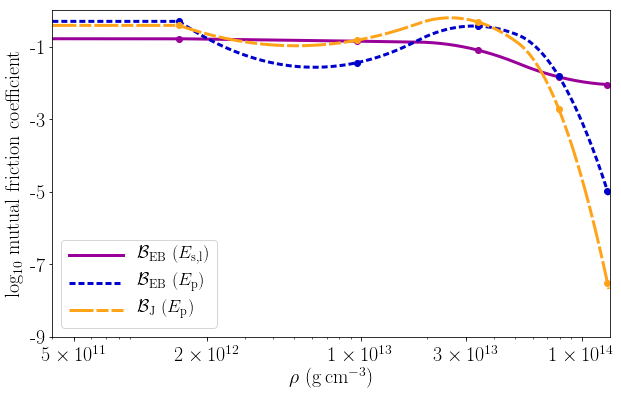

In [34]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

for i in range(1, 4):
    plt.loglog(df_mf[label[0]].values, df_mf[label[i]].values, '.', color=colors[i-1], ms=12)
    plt.loglog(df_mf_fit[label[0]].values, df_mf_fit[label[i]].values, '-', linewidth='3', color=colors[i-1], 
               label=label[i], dashes=linestyle[i-1])

plt.xlim(4e11, 1.35e14)
plt.ylim(1e-9, 1e-0)
plt.xlabel(r'$\rho$ (g$\,$cm$^{-3}$)')
plt.ylabel(r'log$_{10}$ mutual friction coefficient')
ax = fig.get_axes()[0]
ax.set_xticks(np.array([5e11, 2e12, 1e13, 3e13, 1e14]))
ax.set_xticklabels([r'$5 \times 10^{11}$', r'$2 \times 10^{12}$',
                    r'$1 \times 10^{13}$', r'$3 \times 10^{13}$', r'$1 \times 10^{14}$'])
ax.set_yticks(np.logspace(-9, -1, 5))
ax.set_yticklabels(np.arange(-9, 0, 2))

plt.legend(loc=3, handlelength=3, fontsize=18)

plt.show()

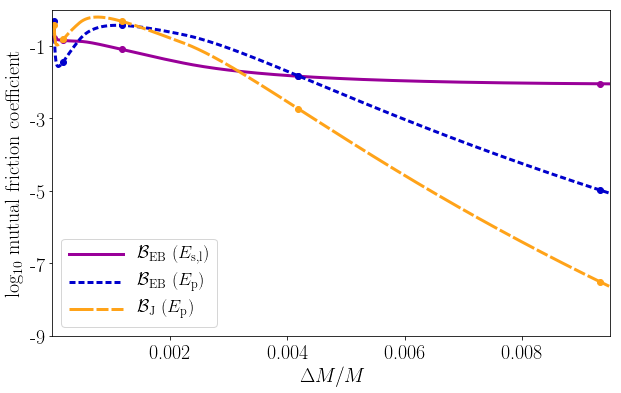

In [35]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

for i in range(1, 4):
    plt.semilogy(fit_rho_rel_mass(df_mf[label[0]].values), df_mf[label[i]].values, '.', color=colors[i-1], ms=12)
    plt.semilogy(fit_rho_rel_mass(df_mf_fit[label[0]].values), df_mf_fit[label[i]].values, '-', linewidth='3', 
                 color=colors[i-1], label=label[i], dashes=linestyle[i-1])

plt.xlim(0.0, 0.0095)
plt.ylim(1e-9, 1e-0)
plt.ylabel(r'log$_{10}$ mutual friction coefficient')
plt.xlabel(r'$\Delta M / M$')
ax = fig.get_axes()[0]
ax.set_xticks(np.arange(0.002, 0.009, 0.002))
ax.set_xticklabels(np.round(np.arange(0.002, 0.009, 0.002), 3))
ax.set_yticks(np.logspace(-9, -1, 5))
ax.set_yticklabels(np.arange(-9, 0, 2))

plt.legend(loc=3, handlelength=3, fontsize=18)

plt.show()

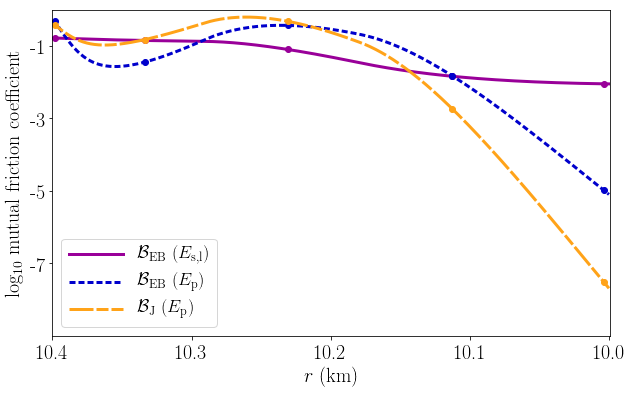

In [36]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

for i in range(1, 4):
    plt.semilogy(fit_rho_radius(df_mf[label[0]].values), df_mf[label[i]].values, '.', color=colors[i-1], ms=12)
    plt.semilogy(fit_rho_radius(df_mf_fit[label[0]].values), df_mf_fit[label[i]].values, '-', linewidth='3', 
                 color=colors[i-1], label=label[i], dashes=linestyle[i-1])

plt.xlim(1.04e6, 0.9999e6)
plt.ylim(1e-9, 1e-0)
plt.xlabel(r'$r$ (km)')
plt.ylabel(r'log$_{10}$ mutual friction coefficient')
ax = fig.get_axes()[0]
ax.set_xticks(np.arange(1e6, 1.05e6, 1e4))
ax.set_xticklabels(np.round(np.arange(1e6, 1.05e6, 1e4)*1e-5, 1))
ax.set_yticks(np.logspace(-7, -1, 4))
ax.set_yticklabels(np.arange(-7, 0, 2))

plt.legend(loc=3, handlelength=3, fontsize=18)

plt.show()

## Rotational evolution
---

To study the rotational evolution, we consider a three-component neutron star toy model. For simplicity, we work in the equatorial plane ($\tilde{r} = r$), integrate the equations of motion in 1D and rescale the results to match the total crustal moment of inertia in cylindrical coordinates with that in spherical geometry.

### Moment of inertias

Total neutron star moment of inertia (see Lattimer & Prakash (2001)):

In [37]:
I_total = 0.35*M_NS*R_NS**2
print(I_total)

1.145172007850807e+45


Moment of inertia of the full crust (from crust-core interface to surface) in spherical coordinates:

In [38]:
def integrand_spherical(r):
    """integrand of the moment of inertia integral in spherical coordinates"""
    return 8*pi/3*fit_radius_rho(r)*r**4


I_crust_total = quad(integrand_spherical, R_cci, R_NS)[0]
print(I_crust_total, I_crust_total/I_total)

1.8316267729743912e+43 0.015994337622798543


Moment of inertia per unit height of the full crust (from crust-core interface to surface) in cylindrical coordinates:

In [39]:
def integrand_cylindrical(r):
    """integrand of the moment of inertia integral in cylindrical coordinates"""
    return 2*pi*fit_radius_rho(r)*r**3


I_crust_total_unitheight = quad(integrand_cylindrical, R_cci, R_NS)[0]
print(I_crust_total_unitheight)

1.3578383726591472e+37


Match the two to obtain height ($2h$) of cylinder

In [40]:
h = I_crust_total/(2*I_crust_total_unitheight)
print(np.round(h))

674464.0


Moments of inertia of the neutron superfluid (95%) and charged particles (5%) in the neutron star core:

In [41]:
I_core = 0.95*(I_total - I_crust_total)
I_protons = 0.05*(I_total - I_crust_total)
print(I_core, I_protons, I_core/I_total, I_protons/I_total)

1.0705129531150099e+45 5.634278700605315e+43 0.9348053792583413 0.04920028311886007


Moment of inertia of the crustal superfluid (integration between crust-core interface and neutron drip):

In [42]:
R_drip = fit_rho_radius(rho_drip)
print(np.round(R_drip/1e5, 3))

def integrand_I(r, h):
    """integrand of the moment of inertia integral in cylindrical oordinates"""
    return 4*pi*h*fit_radius_rho(r)*r**3


I_sf = quad(integrand_I, R_cci, R_drip, args=(h,))[0]
print(I_sf, I_sf/I_total)

10.44
1.8292758132211472e+43 0.015973808307227375


Moment of inertia of the outer crust plus the charged particle conglomerate in the core (dominated by the core protons):

In [43]:
I_crust = I_total - I_core - I_sf
print(I_crust, I_crust/I_total)

5.636629660358567e+43 0.049220812434431306


### Differential equations

We illustrate how the density-dependent mutual friction parameters affect the glitch rise by numerically integrating the differential equations given in Section 4 of Graber et al. (2018). We take crust and core to rotate rigidly and coupled via a constant mutual friction coefficient (we choose two fiducial values ${\cal B}_{\rm core} \approx 5 \times 10^{-5}$ and ${\cal B}_{\rm core} \approx 10^{-2}$ associated with electron-vortex scattering and vortex-fluxtube coupling, respectively), while the superfluid can exhibit differential rotation.

In [44]:
B_core_weak = 5e-5
B_core_strong = 1e-2

In [45]:
def equations_of_motion(y, t, x, n, dx, h, rho_x, R_drip, I_crust, I_core, B_crust, B_core):
    """equations of motion of the three-component toy model"""

    # array of n sf values (due to differential rotation) plus one core and one crust value
    omega_sf = y[:-2]
    omega_core = y[-2]
    omega_crust = y[-1]

    # r-derivative, which we take to vanish at the boundaries
    domdr = (omega_sf[2:] - omega_sf[:-2])/(2*dx)
    domdr = np.append(0.0, domdr)
    domdr = np.append(domdr, 0.0)

    # change in superfluid and core angular velocities
    del_om_sf = B_crust*(2*omega_sf + x*domdr)*(omega_crust - omega_sf)
    del_om_core = 2*omega_core*B_core*(omega_crust - omega_core)

    # ignoring the external torque, crustal component is initially in equilibrium
    del_om_crust = 0.0
    for rho_n, do_n, x_n in zip(rho_x, del_om_sf, x):
        del_om_crust -= rho_n*do_n*x_n**3*dx

    del_om_crust = del_om_crust*4*pi*h*R_drip**4/I_crust

    del_om_crust -= I_core*del_om_core/I_crust

    derivatives = np.append(del_om_sf, del_om_core)
    derivatives = np.append(derivatives, del_om_crust)

    return derivatives

In [46]:
def time_step(t, omega_sf, omega_core, omega_crust, x, n, dx, h, rho_x, R_drip,
              I_crust, I_core, B_crust, B_core):
    """integrating the equations of motion in time"""
    # initial conditions
    y0 = np.append(omega_sf, omega_core)
    y0 = np.append(y0, omega_crust)
    # integration
    y = odeint(equations_of_motion, y0, t, args=(x, n, dx, h, rho_x, R_drip, I_crust, I_core, B_crust, B_core), 
               mxstep=500000)
    return y

Setting up the 1D spatial grid between crust-core interface and neutron drip:

In [47]:
n = 100
dx = (1 - R_cci/R_drip)/n
x = R_cci/R_drip + np.arange(n+1)*dx
rho_x = fit_radius_rho(x*R_drip)

Initial values typical for the Vela pulsar (core and crust are in equilibrium, whereas superfluid has a (positive) initial lag everywhere in the inner crust) as well as a critical velocity lag corresponding to our choice of $\Delta v$:

In [48]:
omega_crit = delta_v/R_NS
print(np.round(omega_crit, 4))

0.0062


In [49]:
omega_Vela = 2*pi*11.195
omega_core_0 = 1*omega_Vela
omega_crust_0 = 1*omega_Vela
rel_om_crit = omega_crit/omega_crust_0
omega_sf_0 = omega_crust_0*np.ones(n+1)*(1 + rel_om_crit)
print(np.round(omega_core_0, 4),
      np.round(omega_sf_0[0], 4),
      rel_om_crit)

70.3403 70.3465 8.828473505114694e-05


Grid for time integration (stop at $120 \, {\rm s}$ to include current limit on glitch rise)

In [50]:
t_end = 120
n_t = 20000
dt = t_end/n_t
t = np.arange(0, t_end + dt, dt)

0.006


### Mutual friction profiles

$\mathcal{B}$ as a function of grid points $x$ and four constant coefficient for comparison $\mathcal{B} = 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4}$:

In [51]:
label_x = [r'$x$', r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$\mathcal{B}_{\rm EB}$ ($E_{\rm s,l}$)',
           r'$\mathcal{B}_{\rm EB}$ ($E_{\rm p}$)', r'$\mathcal{B}_{\rm J}$ ($E_{\rm p}$)']

In [52]:
df_mf_x = pd.DataFrame(columns=label_x)
df_mf_x[label_x[0]] = x

for i in range(1, 5):
    df_mf_x[label_x[i]] = 10**(-i)*np.ones(n+1)

for i in range(5, 8):
    df_mf_x[label_x[i]] = np.array([fit_radius_drag(x0*R_drip, i-4, df_mf[r'$\rho$'][0]) for x0 in x])

## Weak core mutual friction
---

Integrating the equations of motions for case of weak core mutual friction, i.e. ${\cal B}_{\rm core} \approx 5 \times 10^{-5}$, and seven mutual friction profiles:

In [53]:
integration_results_weak = {}

for i in range(7):
    integration_results_weak[i] = time_step(t, omega_sf_0, omega_core_0, omega_crust_0, x, n, dx, h, rho_x, 
                                            R_drip, I_crust, I_core, df_mf_x[label_x[i+1]], B_core_weak)

### Superfluid differential rotation

$\Omega_{\rm sf}$ as a function of position for several time steps for strongest drag $\mathcal{B}_{\rm EB}$ (with $E_{\rm s,l}$):

In [54]:
drag_test = 4

In [55]:
imagelist_sf_weak = [(integration_results_weak[drag_test][i][:-2]) for i in range(len(t))]
t_select = np.array([0, 1, 5, 40, 500, 2000, 8000])
t_passed = np.round(t_select*dt, 3)
print(t_passed)

[0.0e+00 6.0e-03 3.0e-02 2.4e-01 3.0e+00 1.2e+01 4.8e+01]


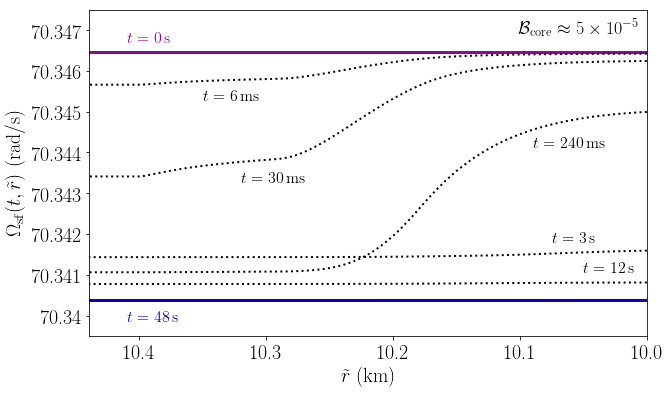

In [56]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[0]], '-', linewidth=3, color=colors[0])
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[1]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[2]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[3]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[4]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[5]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[6]], '-', linewidth=3, color=colors[1])

plt.xlim(R_drip*1e-5, R_cci*1e-5)
plt.ylim(70.3395, 70.3475)
plt.xlabel(r'$\tilde{r}$ (km)')
plt.ylabel(r'$\Omega_{\rm sf}(t,\tilde{r})$  $({\rm rad}/{\rm s})$')
ax = fig.get_axes()[0]
ax.set_xticks(np.arange(R_cci*1e-5, R_drip*1e-5,0.1))
ax.set_xticklabels(np.round(np.arange(R_cci*1e-5, R_drip*1e-5,0.1),1))
ax.set_yticks(np.arange(70.340, 70.348,0.001))
ax.set_yticklabels(np.round(np.arange(70.340, 70.348,0.001),3))

plt.annotate(r'$t = 0 \, {\rm s}$', xy=(10.41,70.3467), fontsize=16, color=colors[0])
plt.annotate(r'$t = 6 \, {\rm ms}$', xy=(10.35,70.34525), fontsize=16)
plt.annotate(r'$t = 30 \, {\rm ms}$', xy=(10.32,70.34325), fontsize=16)
plt.annotate(r'$t = 240 \, {\rm ms}$', xy=(10.09,70.3441), fontsize=16)
plt.annotate(r'$t = 3 \, {\rm s}$', xy=(10.075,70.34181), fontsize=16)
plt.annotate(r'$t = 12 \, {\rm s}$', xy=(10.05,70.34103), fontsize=16)
plt.annotate(r'$t = 48 \, {\rm s}$', xy=(10.41,70.33985), fontsize=16, color=colors[1])
plt.annotate(r'${\cal B}_{\rm core} \approx 5 \times 10^{-5}$', xycoords='axes fraction', 
             xy=(0.77,1 - 0.08), fontsize=18)

plt.show()

Animation of the time evolution of the superfluid component and the non-superfluid 'crust' component:

In [57]:
imagelist_crust_weak = np.array(
    [integration_results_weak[drag_test][:, -1][i]*np.ones(len(x)) for i in range(len(t))])

In [58]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Graber et al. (2018)'))

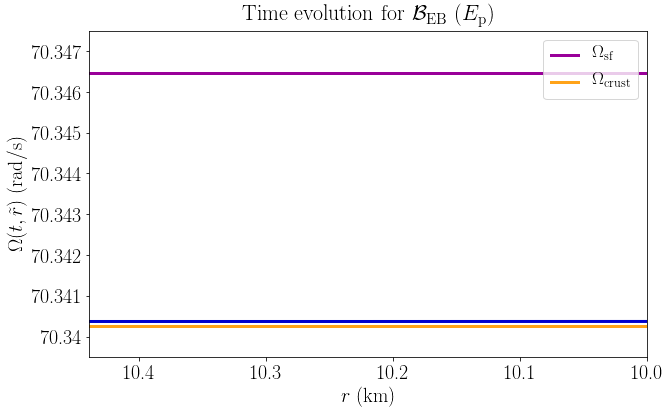

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})
plt.title(r'Time evolution for {}'.format(label_x[6]), fontsize=22)

plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[0]], ':', 
         linewidth=3, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_weak[t_select[6]], '-', 
         linewidth=3, color=colors[1])

ax = fig.get_axes()[0]

line1, = ax.plot(x*R_drip*1e-5, imagelist_sf_weak[0], '-', 
                 linewidth=3, color=colors[0], label=r'$\Omega_{\rm sf}$')
line2, = ax.plot(x*R_drip*1e-5, imagelist_crust_weak[0], '-', 
                 linewidth=3, color=colors[2], label=r'$\Omega_{\rm crust}$')

plt.xlim(R_drip*1e-5, R_cci*1e-5)
plt.ylim(70.3395, 70.3475)
plt.xlabel(r'$r$ (km)')
plt.ylabel(r'$\Omega(t,\tilde{r})$  $({\rm rad}/{\rm s})$')
ax = fig.get_axes()[0]
ax.set_xticks(np.arange(R_cci*1e-5, R_drip*1e-5,0.1))
ax.set_xticklabels(np.round(np.arange(R_cci*1e-5, R_drip*1e-5,0.1),1))
ax.set_yticks(np.arange(70.340, 70.348,0.001))
ax.set_yticklabels(np.round(np.arange(70.340, 70.348,0.001),3))

# update the data

def animate(i):
    line1.set_ydata(imagelist_sf_weak[i])
    line2.set_ydata(imagelist_crust_weak[i])
    return line1, line2

plt.legend(loc=1, handlelength=1.5, fontsize=18)

ani = animation.FuncAnimation(fig, animate, np.arange(0, 5000, 2))

In [60]:
HTML(ani.to_html5_video())

### Crustal evolution and phase shift

Change in crustal frequency over time, the equilibrium value expected from angular momentum conservation and fractional glitch step-size calculated for comparison with Palfreyman et al. (2018) as well as the relative-vortex nucleus velocity related to the observed step size

In [61]:
df_delomega_crust_weak = pd.DataFrame(columns=label_x[1:])

for i in range(7):
    df_delomega_crust_weak[label_x[i + 1]] = (integration_results_weak[i][:, -1] - omega_crust_0)/(2*pi)

In [62]:
del_nu_equilibrium = omega_crust_0 / (2*pi) * rel_om_crit * I_sf/(I_crust + I_core)*1e6
print(np.round(del_nu_equilibrium, 1))

16.0


In [63]:
frac_nu = del_nu_equilibrium*1e-6*2*pi/omega_crust_0
print(np.round(frac_nu, 9))

1.433e-06


In [64]:
print(np.round((I_crust + I_core)/I_sf*1.431e-06*omega_crust_0*R_NS))

6690.0


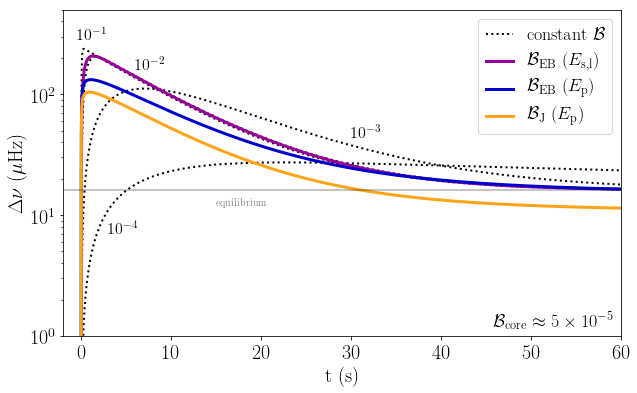

In [65]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

plt.plot(t, 1e6*df_delomega_crust_weak[label_x[1]], ':', label=r'constant $\mathcal{B}$', 
         linewidth=2, color='black')

for i in range(1, 4):
    plt.plot(t, 1e6*df_delomega_crust_weak[label_x[i+1]], ':', label='_nolegend_', 
             linewidth=2, color='black')

for i in range(4, 7):
    plt.plot(t, 1e6*df_delomega_crust_weak[label_x[i+1]], '-', label=label[i-3], 
             linewidth=3, color=colors[i-4])

plt.plot([-10, 100], [del_nu_equilibrium,
                      del_nu_equilibrium], 'black', alpha=0.3)

plt.xlim(-2,60)
plt.ylim(1,5e2)
plt.xlabel(r't (s)')
plt.ylabel(r'$\Delta\nu\ (\mu{\rm Hz})$')
ax = fig.get_axes()[0]
ax.set_yscale('log')

plt.annotate(r'$10^{-1}$', xy=(-0.5,2.8e2), fontsize=16)
plt.annotate(r'$10^{-2}$', xy=(6,1.6e2), fontsize=16)
plt.annotate(r'$10^{-3}$', xy=(30,4.3e1), fontsize=16)
plt.annotate(r'$10^{-4}$', xy=(3,0.7e1), fontsize=16)
plt.annotate(r'equilibrium', xy=(15,1.2e1), fontsize=10, alpha=0.5)
plt.annotate(r'${\cal B}_{\rm core} \approx 5 \times 10^{-5}$', 
             xycoords='axes fraction', xy=(0.77,0.02), fontsize=18)

plt.legend(loc=1, handlelength=1.5, fontsize=18)

plt.show()

Illustrate crust-core coupling via phase shift accumulated after a glitch:

In [66]:
def phi(delta_nu, dt):
    """ phase shift accumulated after a glitch as function of time """
    
    phase = np.array([])
    for i in range(len(delta_nu)):
        phase = np.append(phase, np.sum(dt*delta_nu[:i+1]))
    return phase

In [67]:
df_phi_weak = pd.DataFrame(columns=label_x[1:])

for i in range(7):
    df_phi_weak[label_x[i + 1]] = phi(df_delomega_crust_weak[label_x[i + 1]], dt)

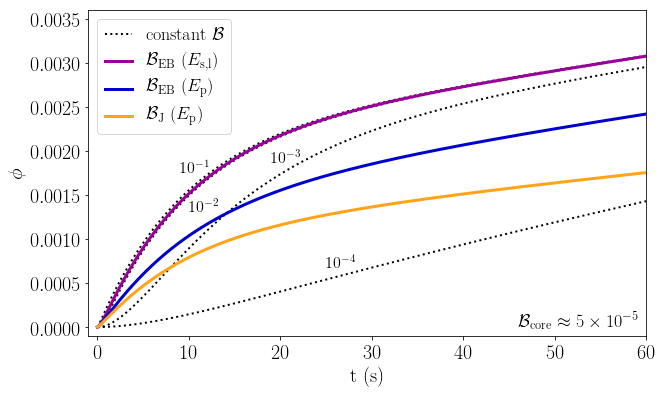

In [68]:
fig = plt.figure()
fig.set_size_inches(10, 6)
mpl.rcParams.update({'font.size': 20})

plt.plot(t, df_phi_weak[label_x[1]], ':', label=r'constant $\mathcal{B}$', 
         linewidth=2, color='black')

for i in range(1, 4):
    plt.plot(t, df_phi_weak[label_x[i+1]], ':', label='_nolegend_', 
             linewidth=2, color='black')

for i in range(4, 7):
    plt.plot(t, df_phi_weak[label_x[i+1]], '-', label=label_x[i+1], 
             linewidth=3, color=colors[i-4])

plt.xlim(-1,60)
plt.ylim(-0.0001,0.0036)
plt.xlabel(r't (s)')
plt.ylabel(r'$\phi$')

plt.annotate(r'$10^{-1}$', xy=(9,1.75e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-2}$', xy=(10,1.3e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-3}$', xy=(19,1.86e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-4}$', xy=(25,0.67e-3), rotation=0, fontsize=16)
plt.annotate(r'${\cal B}_{\rm core} \approx 5 \times 10^{-5}$', xycoords='axes fraction', 
             xy=(0.77,0.02), fontsize=18)

plt.legend(loc=2, handlelength=1.5, fontsize=18)

plt.show()

Crust-core coupling timescales for different core mutual friction strengths:

In [69]:
print(np.round((I_crust/I_core)*1/(2*omega_core_0*1e-2), 3),
      np.round((I_crust/I_core)*1/(2*omega_core_0*1e-4), 1),
      np.round((I_crust/I_core)*1/(2*omega_core_0*5e-5)))

0.037 3.7 7.0


## Strong core mutual friction
---

Repeat the above calculations to obtain glitch rise predictions for ${\cal B}_{\rm core} \approx 10^{-2}$.

In [70]:
integration_results_strong = {}

for i in range(7):
    integration_results_strong[i] = time_step(t, omega_sf_0, omega_core_0, omega_crust_0, x, n, dx, h, 
                                              rho_x, R_drip, I_crust, I_core, df_mf_x[label_x[i+1]], B_core_strong)

### Superfluid differential rotation

$\Omega_{\rm sf}$ as a function of position for several time steps for strongest drag $\mathcal{B}_{\rm EB}$ (with $E_{\rm s,l}$):

In [71]:
imagelist_sf_strong = [(integration_results_strong[drag_test][i][:-2]) for i in range(len(t))]

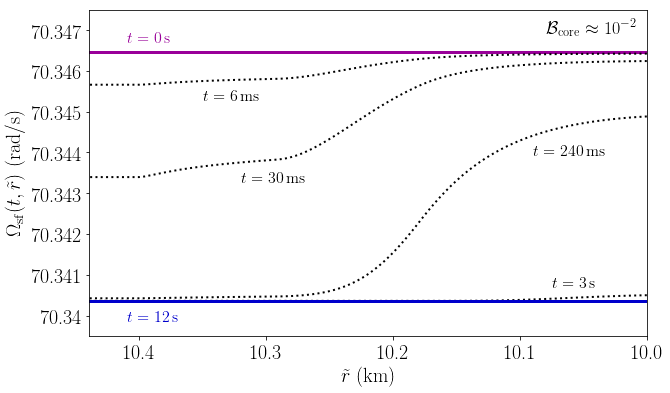

In [72]:
fig = plt.figure()
fig.set_size_inches(10,6)
mpl.rcParams.update({'font.size': 20})

plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[0]], '-', linewidth=3, color=colors[0])
plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[1]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[2]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[3]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[4]], ':', linewidth=2, color='black')
plt.plot(x*R_drip*1e-5, imagelist_sf_strong[t_select[5]], '-', linewidth=3, color=colors[1])

plt.xlim(R_drip*1e-5, R_cci*1e-5)
plt.ylim(70.3395, 70.3475)
plt.xlabel(r'$\tilde{r}$ (km)')
plt.ylabel(r'$\Omega_{\rm sf}(t,\tilde{r})$  $({\rm rad}/{\rm s})$')
ax = fig.get_axes()[0]
ax.set_xticks(np.arange(R_cci*1e-5, R_drip*1e-5,0.1))
ax.set_xticklabels(np.round(np.arange(R_cci*1e-5, R_drip*1e-5,0.1),1))
ax.set_yticks(np.arange(70.340, 70.348,0.001))
ax.set_yticklabels(np.round(np.arange(70.340, 70.348,0.001),3))

plt.annotate(r'$t = 0 \, {\rm s}$', xy=(10.41,70.3467), fontsize=16, color=colors[0])
plt.annotate(r'$t = 6 \, {\rm ms}$', xy=(10.35,70.34525), fontsize=16)
plt.annotate(r'$t = 30 \, {\rm ms}$', xy=(10.32,70.34325), fontsize=16)
plt.annotate(r'$t = 240 \, {\rm ms}$', xy=(10.09,70.3439), fontsize=16)
plt.annotate(r'$t = 3 \, {\rm s}$', xy=(10.075,70.3407), fontsize=16)
plt.annotate(r'$t = 12 \, {\rm s}$', xy=(10.41,70.33985), fontsize=16, color=colors[1])
plt.annotate(r'${\cal B}_{\rm core} \approx 10^{-2}$', xycoords='axes fraction', xy=(0.82,1-0.08), fontsize=18)

plt.show()

### Crustal evolution and phase shift

Change in crustal frequency over time. Glitch size remains the same.

In [73]:
df_delomega_crust_strong = pd.DataFrame(columns=label_x[1:])

for i in range(7):
    df_delomega_crust_strong[label_x[i + 1]] = (integration_results_strong[i][:,-1] - omega_crust_0)/(2*pi)

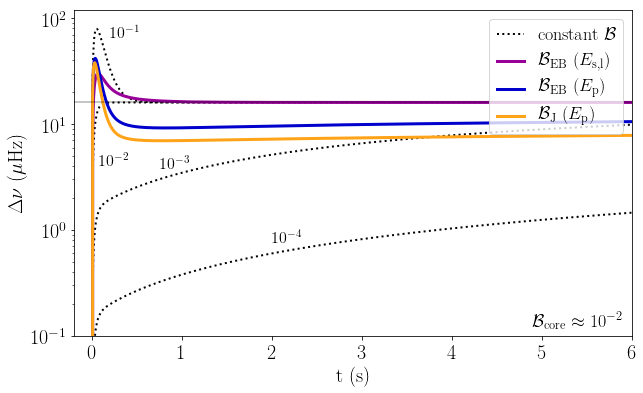

In [74]:
fig = plt.figure()
fig.set_size_inches(10,6)
mpl.rcParams.update({'font.size': 20})

plt.plot(t, 1e6*df_delomega_crust_strong[label_x[1]], ':', label=r'constant $\mathcal{B}$', 
         linewidth=2, color='black')

for i in range(1,4):
    plt.plot(t, 1e6*df_delomega_crust_strong[label_x[i+1]], ':', label='_nolegend_', 
             linewidth=2, color='black')
    
for i in range(4,7): 
    plt.plot(t, 1e6*df_delomega_crust_strong[label_x[i+1]], '-', label=label[i-3], 
             linewidth=3, color=colors[i-4])

plt.plot([-10,100], [del_nu_equilibrium, del_nu_equilibrium], 'black', alpha=0.3);

plt.xlim(-0.2,6)
plt.ylim(1e-1,1.2e2)
plt.xlabel(r't (s)')
plt.ylabel(r'$\Delta\nu\ (\mu{\rm Hz})$')
ax = fig.get_axes()[0]
ax.set_yscale('log')

plt.annotate(r'$10^{-1}$', xy=(0.2,0.65e2), fontsize=16)
plt.annotate(r'$10^{-2}$', xy=(0.08,0.4e1), fontsize=16)
plt.annotate(r'$10^{-3}$', xy=(0.75,0.38e1), fontsize=16)
plt.annotate(r'$10^{-4}$', xy=(2,7.5e-1), fontsize=16)
plt.annotate(r'${\cal B}_{\rm core} \approx 10^{-2}$', xycoords='axes fraction', xy=(0.82,0.02), fontsize=18)

plt.legend(loc=1, handlelength=1.5, fontsize=18);

plt.show()

Phase shift for the stronger core friction (break shifted to the left)

In [75]:
df_phi_strong = pd.DataFrame(columns=label_x[1:])

for i in range(7):
    df_phi_strong[label_x[i + 1]] = phi(df_delomega_crust_strong[label_x[i + 1]], dt)

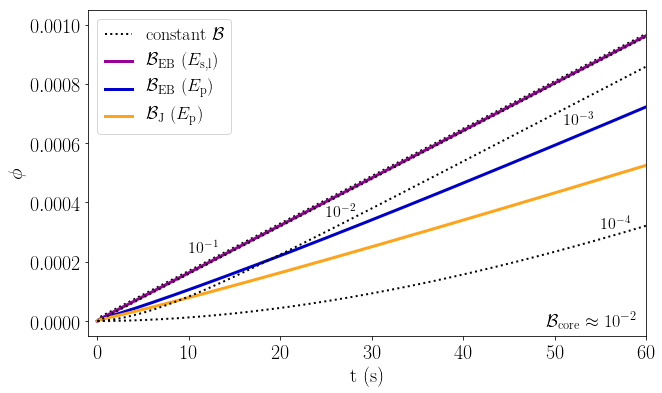

In [76]:
fig = plt.figure()
fig.set_size_inches(10,6)
mpl.rcParams.update({'font.size': 20})

plt.plot(t, df_phi_strong[label_x[1]], ':', label=r'constant $\mathcal{B}$', 
         linewidth=2, color='black')
    
for i in range(4,7):
    plt.plot(t, df_phi_strong[label_x[i+1]], '-', label=label_x[i+1], 
             linewidth=3, color=colors[i-4])
    
for i in range(1,4):
    plt.plot(t, df_phi_strong[label_x[i+1]], ':', label='_nolegend_', 
             linewidth=2, color='black')

plt.xlim(-1,60)
plt.ylim(-0.00005,0.00105)
plt.xlabel(r't (s)')
plt.ylabel(r'$\phi$')

plt.annotate(r'$10^{-1}$', xy=(10,0.23e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-2}$', xy=(25,0.35e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-3}$', xy=(51,0.66e-3), rotation=0, fontsize=16)
plt.annotate(r'$10^{-4}$', xy=(55,0.31e-3), rotation=0, fontsize=16)
plt.annotate(r'${\cal B}_{\rm core} \approx 10^{-2}$', xycoords='axes fraction', 
             xy=(0.82,0.02), fontsize=18)

plt.legend(loc=2, handlelength=1.5, fontsize=18);

plt.show()

## Timing residuals prediction
---

To compare predicted glitch rises with recent pulse-to-pulse observations of a Vela glitch, timing residuals associated with the models are calculated. Provided that residuals and change in pulsar rotation frequency are small, residuals are given by $- \phi /\nu_{\rm crust}(0) = - 2\pi  \phi / \Omega_{\rm crust}(0)$. Redo integration for weak core coupling ${\cal B}_{\rm core} \approx 5 \times 10^{-5}$ using a modified grid for the integration, i.e. a timestep of $1\,$s.

In [77]:
t_end_TOAs = 120
n_t_TOAs = 120
dt_TOAs = t_end_TOAs/n_t_TOAs
t_TOAs = np.arange(0, t_end_TOAs + dt_TOAs, dt_TOAs)
print(dt_TOAs)

1.0


In [78]:
integration_results_TOAs = {}
df_delomega_crust_TOAs = pd.DataFrame(columns=label_x[1:])
df_phi_TOAs = pd.DataFrame(columns=label_x[1:])

for i in range(7):
    integration_results_TOAs[i] = time_step(t_TOAs, omega_sf_0, omega_core_0, omega_crust_0, x, n, dx, h, rho_x, 
                                            R_drip, I_crust, I_core, df_mf_x[label_x[i+1]], B_core_weak)

for i in range(7):
    df_delomega_crust_TOAs[label_x[i + 1]] = (integration_results_TOAs[i][:,-1] - omega_crust_0)/(2*pi)

for i in range(7):
    df_phi_TOAs[label_x[i + 1]] = phi(df_delomega_crust_TOAs[label_x[i + 1]], dt_TOAs)

Timing residuals in ms

In [79]:
df_model_TOAs = pd.DataFrame(columns=label_x[1:])

df_model_TOAs = - df_phi_TOAs*2*pi*1e3/omega_crust_0
df_model_TOAs['t'] = t_TOAs

Export results for data comparison in acconmpanying notebook.

In [80]:
df_model_TOAs.to_csv('model_residuals.txt', sep='&', index=False, header=True)

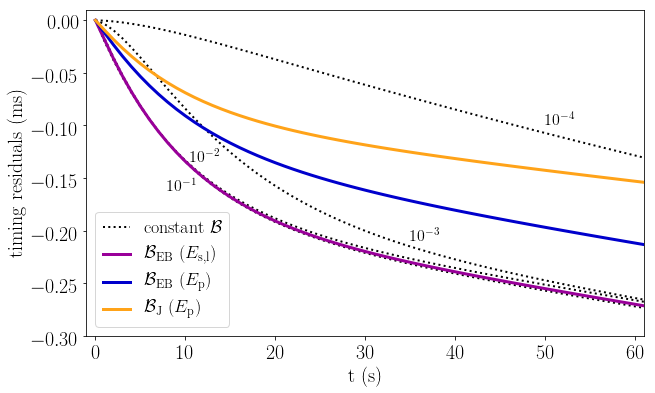

In [81]:
fig = plt.figure()
fig.set_size_inches(10,6)
mpl.rcParams.update({'font.size': 20})

plt.plot(t_TOAs, df_model_TOAs[label_x[1]], ':', label=r'constant $\mathcal{B}$', linewidth=2, color='black')

for i in range(1,4):
    plt.plot(t_TOAs, df_model_TOAs[label_x[i+1]], ':', label='_nolegend_', linewidth=2, color='black')
    
for i in range(4,7):
    plt.plot(t_TOAs, df_model_TOAs[label_x[i+1]], '-', label=label_x[i+1], linewidth=3, color=colors[i-4])

plt.xlim(-1,61)
plt.ylim(-0.3,0.01)
plt.xlabel(r't (s)')
plt.ylabel(r'timing residuals (ms)')

plt.annotate(r'$10^{-1}$', xy=(8,-0.162), rotation=0, fontsize=16)
plt.annotate(r'$10^{-2}$', xy=(10.5,-0.135), rotation=0, fontsize=16)
plt.annotate(r'$10^{-3}$', xy=(35,-0.21), rotation=0, fontsize=16)
plt.annotate(r'$10^{-4}$', xy=(50,-0.1), rotation=0, fontsize=16)

plt.legend(loc=3, handlelength=1.5, fontsize=18);

plt.show()